In [1]:
# EMAIL SPAM DETECTION WITH MACHINE LEARNING  #Avinash Jamdade

# **EMAIL SPAM DETECTION WITH MACHINE LEARNING**
* We've all been the recipient of spam emails before. Spam mail, or junk mail, is a type of email that is sent to a massive number of users at one time, frequently containing cryptic messages, scams, or most dangerously, phishing content.

* In this Project, use Python to build an email spam detector. Then, use machine learning to train the spam detector to recognize and classify emails into spam and non-spam. Lets get started!

<span style="font-size: 14px; font-family: Verdana; border: 2px solid #ccc;background-color: #F5F5F5; padding: 10px; border-radius: 10px; display: inline-block; margin-bottom: 20px;">
  The primary goal of this notebook is to develop a predictive model that accurately classifies incoming SMS messages as either <span style="background-color: #FF5733; color: white; font-weight: bold; padding: 3px 6px; border-radius: 3px;">ham</span> or <span style="background-color: #FF5733; color: white; font-weight: bold; padding: 3px 6px; border-radius: 3px;">spam</span>. We will use the SMS Spam Collection dataset, which consists of 5,574 SMS messages tagged with their respective labels.
</span>


# Importaant Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

# Data Loading and Preprocessing:

In [3]:
df = pd.read_csv("/content/spam.csv", encoding = 'ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop(columns=df.columns[2:])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.columns = ['Category', 'Message']
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [7]:
set(df.duplicated())

{False, True}

In [8]:
df.duplicated().sum()

403

In [9]:
df = df.drop_duplicates(subset=['Message'])

In [10]:
df.duplicated().sum()

0

In [11]:
set(df.duplicated())

{False}

# EDA and Visualization:



In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5169 non-null   object
 1   Message   5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [13]:
df.describe().T

,count,unique,top,freq
Category,5169,2,ham,4516
Message,5169,5169,"Go until jurong point, crazy.. Available only ...",1


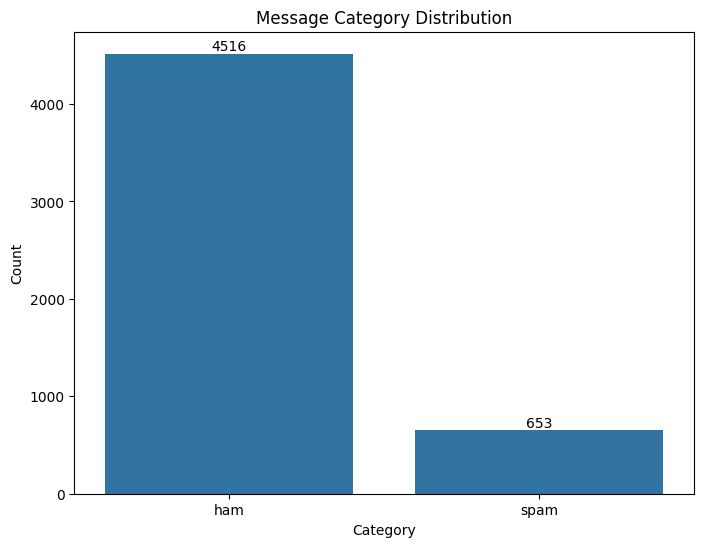

In [14]:
# Count the number of messages in each category
category_counts = df['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=category_counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Message Category Distribution')

# Add text with counts on the bars
for i, count in enumerate(category_counts['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


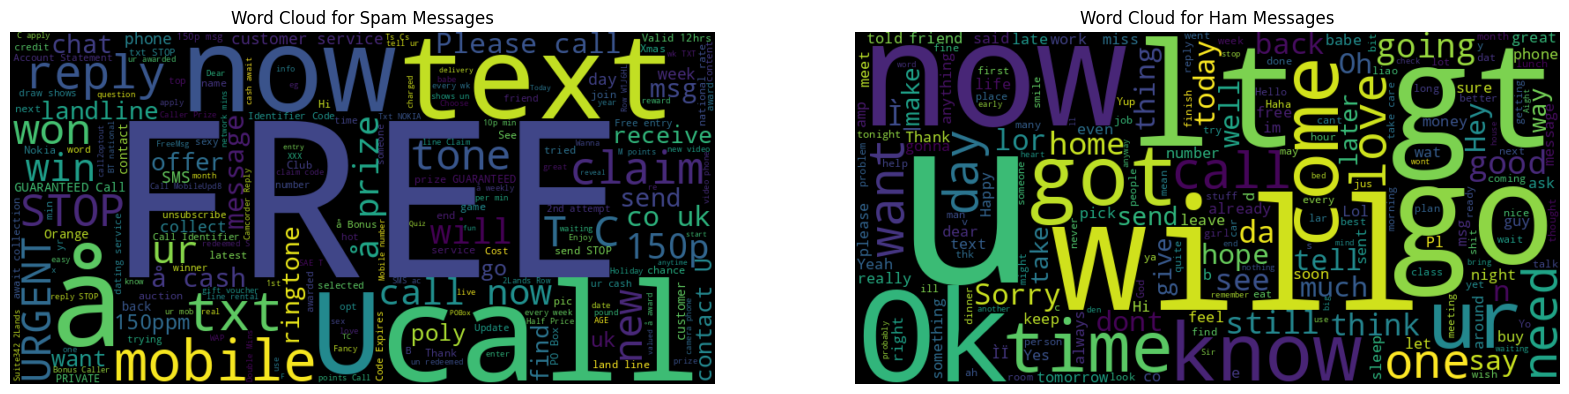

In [15]:
# Create a WordCloud for spam messages
spam_messages = df[df['Category'] == 'spam']['Message']
spam_wordcloud = WordCloud(width=800, height=400).generate(' '.join(spam_messages))

# Create a WordCloud for ham messages
ham_messages = df[df['Category'] == 'ham']['Message']
ham_wordcloud = WordCloud(width=800, height=400).generate(' '.join(ham_messages))

# Plot the word clouds
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.show()


# Label Encoding:



In [16]:
df['spam']= df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


# Train-Test Split:



In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], train_size=.8)

# Feature Extraction (Count Vectorization):



In [18]:
from sklearn.feature_extraction.text import CountVectorizer
featurizer = CountVectorizer()
X_train_count = featurizer.fit_transform(X_train.values)

In [19]:
X_train_count

<4135x7669 sparse matrix of type '<class 'numpy.int64'>'
	with 54756 stored elements in Compressed Sparse Row format>

# Model Training:



In [20]:
model = MultinomialNB()
model.fit(X_train_count,y_train)

MultinomialNB()

In [28]:
emails = [
    'Hey can we get together to watch football game tomorrow?',
    'Upto 20% discount on parking, exclusive offer just for you. Dont miss this reward!'
]
emails_count = featurizer.transform(emails)
model.predict(emails_count)

array([0, 1])

In [29]:
X_test_count = featurizer.transform(X_test)
model.score(X_test_count, y_test)

0.9854932301740812

# Building a Pipeline:



In [23]:
from sklearn.pipeline import Pipeline
clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])

## Evaluating the Pipeline:



In [24]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

### Making Predictions with the Pipeline:



In [25]:
clf.score(X_test,y_test)

0.9854932301740812

In [26]:
clf.predict(emails)

array([0, 1])

# Confusion Matrix Visualization:

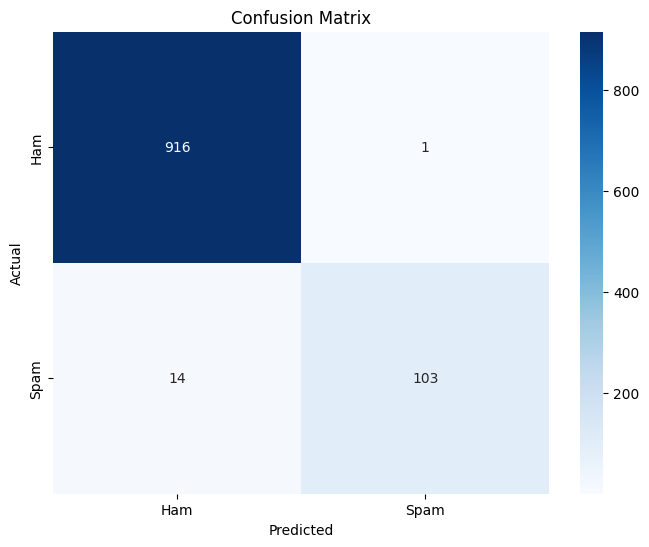

In [27]:
y_pred = model.predict(X_test_count)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
